# Results (Click on the links below to navigate to that section)

## [Sports](#Sports-Articles-Results)

## [Technology](#Technology-Articles-Results)

## [Politics](#Politics-Articles-Results)

## [Entertainment](#Entertainment-Articles-Results)

## [Business](#Business-Articles-Results)

In [77]:
# General Packages
import numpy as np
import pandas as pd
import re
import itertools
from matplotlib import pyplot as plt
import wikipedia
from bs4 import BeautifulSoup
import requests
import seaborn as sns

# NLP packages
from nltk.corpus import stopwords
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy import displacy

# Model building packages
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm, tqdm_notebook
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import NMF
from scipy.sparse import hstack, csr_matrix

# LDA modules
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.models import CoherenceModel

In [79]:
def visualize_number(data_frame):
    plt.figure(figsize=(8,5))
    sns.countplot(y = data_frame['num_countries'], orient = 'v')
    plt.title('Number of countries mentioned', fontsize = 15)
    plt.ylabel('Number of countries', fontsize = 10)
    plt.xlabel('Number of articles', fontsize = 10)
    plt.show()

In [3]:
stop = stopwords.words('english')
stop.extend(['said', 'The', 'Mr', 'also', 'year', 'But', 'It', 'In', 'bn', 'mn', 'last', 'would', \
             'could', 'mr', 'A', 'say', 'many', 'They', 'Those', 'That', 'Ask', 'Its'])

def remove_stop(x:pd.Series)-> str:
    '''
    Takes in a Series object and returns a string with necessary modifications done
    '''
    article = x['article']
    tokens = word_tokenize(article)
    rx = re.compile('\w{2,}')
    tokens_without_sw= [word for word in tokens if word not in stop and rx.match(word)]

    return (" ".join(tokens_without_sw))

In [4]:
# All the roots of the G19 countries
g19_countries_root = ["Argenti", "Aussie", "Australia", "Brazil", "Canad", "Chin", "German", \
     "France", "French", "India", "Indonesia", "Japan", "Mexic", "Russia", "Arabia", "Ital",\
     "South Africa", "Korea", "Turk", "US", "United States", "America"]

# All the roots and European countries
european_union_root = ['Austria', 'Belgi', 'Latvia', 'Bulgaria','Lithuania', 'Croatia', 'Luxembourg',\
'Cyprus', 'Malta', 'Czechia', 'Netherland', 'Dutch' 'Denmark', 'Pol', 'Estonia', 'Portug',\
'Fin', 'Romania', 'French', 'France', 'Slovakia', 'Slovenia', 'Gree', 'Spanish', 'Spain', 'Hungar', 'Swed']

# All the roots of United Kingdom countries
uk=["UK", "United Kingdom", "England", "Scottish", "Scotland", "Wales", "Ireland", "Irish"]

# Matching the root words with the countries
matching_dict={"Chin":"China", "Arabia":'Saudi Arabia', "Argenti":"Argentina", 'Hungar': 'Hungary',\
                  'Swed': 'Sweden', "Aussie":"Australia", "Canad":"Canada", "Mexic":"Mexico", \
                  "French": 'France', "America":"US", "Turk":"Turkey", "German":"Germany","Ital":"Italy",\
                  "United States":"US", "uk":"UK"}

In [5]:
def get_entities(article:str)->list:
    '''
    Takes in a string type and return a list of required entities
    '''
    entities = [ent.text for ent in nlp(article).ents if ent.label_ in ['GPE', 'ORG', 'NORP']]
    return list(set(entities))
    

In [6]:
def extract_g20_names(text_summary:str)->set:
    '''
    Takes in a string and returns a set of mentions of G20 countries
    '''
    country_set = set()

    # Add country name if country in G19
    for country in g19_countries_root:
        if country in text_summary:
            country_set.add(country)
            
    # Add EU for any European country
    for country in european_union_root:
        if country in text_summary:
            country_set.add('EU')
    
    # Add UK for any united kingdom country
    for country in uk:
        if country in text_summary:
            country_set.add('UK')
            
    return list(country_set)

def direct_reference(x: pd.Series)->list:
    '''
    Takes in a series object and returns list of direct mentions of G20 countries
    '''
    
    entities = x['entities'] 
          
    # Get any direct mentions of G20 countries in the article
    country_set = extract_g20_names(x['article'])
    
    # Remove the entities with country names
    for country in country_set:
        for entity in entities:
            if country in entity:
                entities.remove(entity)
                
    x['entities'] = entities
    return list(country_set)

In [7]:
def get_info(query_string:str, API='KeywordSearch')-> str:
    '''
    Takes in the query string and uses the API specified to perform required action and send out the description.
    '''
    
    # The default DBPedia URL
    dbpedia_url = 'http://lookup.dbpedia.org/api/search.asmx/'
    api_url = dbpedia_url + API 
    params = {}
    if not params:
        params['QueryString'] = query_string
    
    # Get the content of the required url
    response = requests.get(api_url, params=params)
    soup = BeautifulSoup(response.content, 'xml')
    
    # Extract the most relevant (first result) link summary
    link = soup.find('Description')

    if link is not None:
        return link.text
    return 'None'

In [8]:
def get_referred_countries(x:pd.Series)-> list:
    '''
    Takes in a series object, searches dbpedia page for each entity
    Searches the summaries for mentions of G20 countries and returns a list of these mentions
    '''
    entities = x['entities']
    country_set = set()
    
    for entity in entities:
        summary = get_info(entity)[:250]
        country_set.update(extract_g20_names(summary))
    
    return list(country_set)

In [24]:
def get_all_mentions(x:pd.Series)-> list:
    '''
    Takes in a series object and combines the direct and indirect references and returns a list
    '''
    direct_countries = x['direct_reference']
    referred_countries = get_referred_countries(x)
    
    all_mentioned_countries = set(direct_countries+referred_countries)
    
    return list(all_mentioned_countries)

In [10]:
def consolidate(x:pd.Series)->list:
   '''
   Takes in a series object and converts all the country roots into proper country names.
   '''
    all_mentioned_countries = x['all_mentioned_countries']
   
    for country in all_mentioned_countries:  
        if country in matching_dict.keys():
            all_mentioned_countries.remove(country)
            all_mentioned_countries.append(matching_dict[country])

    return list(set(all_mentioned_countries))

In [11]:
def tokenize(x:pd.Series)->list:
    '''
    Takes in series object and tokenizes the article text in it.
    '''
    text = x['article']
    
    # Tokenize the text
    text = word_tokenize(text)
    
    return text

In [74]:
def get_topics(data_frame: pd.DataFrame)-> pd.DataFrame:
    '''
    Performs Non-negative Matrix Factorization and returns a dataframe with topics and the keywords.
    '''
    vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words=stop)
    vz = vectorizer.fit_transform(data_frame['article'])

    nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(vz)

    feature_names = vectorizer.get_feature_names()
    no_top_words = 10
    word_dict = {}

    for idx, topic in enumerate(nmf.components_[:10]):
        word_dict["Topic %d:"% (idx+1)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]

    df = pd.DataFrame.from_dict(word_dict, orient='index')
    df.columns = ['Keyword {0}'.format(i) for i in range(1, 11)]
        
    return df

In [28]:
def countries_pipeline(data:dict)-> pd.DataFrame:
    '''
    Takes in the data. Returns a DataFrame containing the article as row and the mentioned countries as a column.
    '''
    
    # Store in the data as a DataFrame
    article_df = pd.DataFrame.from_dict(data, orient = 'index', columns=['article'])
    
    # Cleaning (Removing symbols, numbers and stopwords)
    article_df["article"] = article_df["article"].apply(lambda x: re.sub("[^a-zA-Z]+"," ",x))
    article_df["article"] = article_df.apply(remove_stop, axis=1)
    
    # Entity extraction
    article_df["entities"] = article_df["article"].apply(get_entities)
    
    # Listing out any direct references
    article_df['direct_reference'] = article_df.apply(direct_reference, axis=1)
    
    # Combining direct and indirect references
    article_df['all_mentioned_countries'] = article_df.apply(get_all_mentions, axis=1)
    article_df = article_df[["article","all_mentioned_countries"]]
    
    # Replace root of the country with country names
    article_df["all_mentioned_countries"] = article_df.apply(consolidate, axis=1)
    article_df['num_countries'] = article_df["all_mentioned_countries"].str.len()
    
    return article_df

In [68]:
def topics_pipeline(data_frame:pd.DataFrame)->pd.DataFrame:
    '''
    Takes in a DataFrame and returns a DataFrame with topics
    '''
    
    # Makes the necessary changes of getting dummies
    feature_df = pd.concat([data_frame.drop('all_mentioned_countries', axis=1), \
                        pd.get_dummies(data_frame.all_mentioned_countries.apply(pd.Series).stack()).sum(level=0)],axis=1)
    feature_df.fillna(0, inplace=True)
    topics_df = get_topics(feature_df)
    return topics_df

# Sports Articles Results

In [16]:
n=0
sport={}
while True:
    try:
        n = n+1
        file = open('sport/'+str(n).zfill(3)+'.txt', "r")
        sport[n] = file.read()
    except: break
       

In [34]:
sports_df = countries_pipeline(sport)

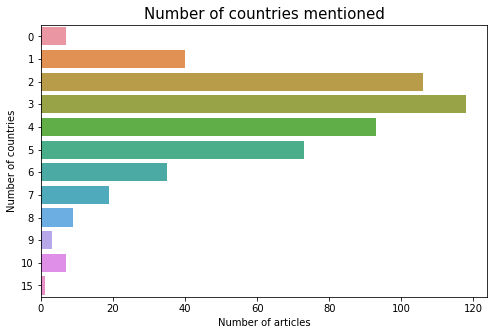

In [80]:
# Number of articles for each individual country 
visualize_number(sports_df)

In [83]:
# Articles that have an overlap in talking about several countries.
sports_df[sports_df.num_countries>1]['article']

1      Claxton hunting first major medal British hurd...
2      Sullivan run Worlds Sonia Sullivan indicated l...
3      Greene sets sights world title Maurice Greene ...
4      IAAF launches fight drugs IAAF athletics world...
5      Dibaba breaks world record Ethiopia Tirunesh D...
                             ...                        
507    Big guns ease San Jose Top seeded Americans An...
508    Almagro continues Spanish surge Unseeded Nicol...
509    Melzer shocks Agassi San Jose Second seed Andr...
510    Mirza makes Indian tennis history Teenager San...
511    Roddick face Saulnier final Andy Roddick play ...
Name: article, Length: 464, dtype: object

In [75]:
topics_pipeline(sports_df)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
Topic 1:,england,robinson,bath,six,nations,six nations,leicester,ireland,wilkinson,barkley
Topic 2:,open,seed,australian,roddick,federer,set,hewitt,australian open,first,final
Topic 3:,chelsea,united,club,arsenal,league,mourinho,game,cup,manager,play
Topic 4:,kenteris,greek,thanou,iaaf,drugs,tests,athens,olympics,charges,doping
Topic 5:,indoor,holmes,olympic,european,record,world,britain,champion,gold,race
Topic 6:,ireland,gara,try,penalty,driscoll,italy,half,murphy,easterby,irish
Topic 7:,liverpool,gerrard,benitez,parry,steven,anfield,champions league,morientes,reds,rafael benitez
Topic 8:,wales,williams,france,jones,ruddock,nations,thomas,scotland,six nations,italy
Topic 9:,lions,rugby,zealand,new zealand,woodward,tour,new,dallaglio,blacks,hemisphere
Topic 10:,radcliffe,cross country,marathon,race,chepkemei,cross,country,london,paula,world cross


## Sports Cluster topics

Topic 1: England and Irish sports

Topic 2: Australian Open

Topic 3: Soccer Premier League updates and news

Topic 4: Olympics drug testing and scandals

Topic 5: Olympic indoor sports

Topic 6: European Rugby news

Topic 7: Soccer Champions League updates and news

Topic 8: Boxing updates

Topic 9: New Zealand Rugby news

Topic 10: track and field events

# Technology Articles Results

In [38]:
n=0
tech={}
while True:
    try:
        n=n+1
        file = open('tech/'+str(n).zfill(3)+'.txt', "r")
        tech[n] = file.read()
    except: break
       

In [39]:
tech_df = countries_pipeline(tech)

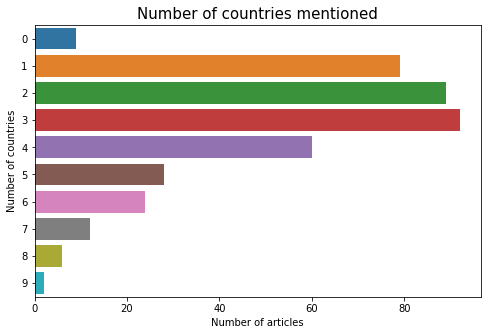

In [84]:
# Number of articles for each individual country 
visualize_number(tech_df)

In [85]:
# Articles that have an overlap in talking about several countries.
tech_df[tech_df.num_countries>1]['article']

1      Ink helps drive democracy Asia Kyrgyz Republic...
4      Digital guru floats sub PC Nicholas Negroponte...
5      Technology gets creative bug hi tech arts worl...
6      Wi fi web reaches farmers Peru network communi...
8      Virus poses Christmas mail Security firms warn...
                             ...                        
395    Cebit fever takes Hanover Thousands products t...
396    New consoles promise big problems Making games...
398    Spam mails tempt net shoppers Computer users a...
399    Be careful code new European directive put sof...
401    Losing online gaming Online role playing games...
Name: article, Length: 313, dtype: object

In [43]:
topics_pipeline(tech_df)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
Topic 1:,search,people,digital,tv,technology,music,net,content,one,video
Topic 2:,virus,spyware,security,microsoft,mail,anti,software,windows,anti virus,program
Topic 3:,game,games,titles,xbox,halo,ea,gaming,awards,play,title
Topic 4:,mobile,phone,phones,mobiles,mobile phone,handsets,camera,mobile phones,multimedia,operators
Topic 5:,apple,mac,mac mini,mini,ipod,music,jobs,digital music,market,machine
Topic 6:,broadband,bt,uk,connections,net,speeds,calls,lines,million,fast
Topic 7:,peer,bittorrent,file,sharing,files,file sharing,peer peer,legal,networks,movie
Topic 8:,nintendo,ds,sony,psp,handheld,console,gaming,japan,march,device
Topic 9:,dvd,ray,dvds,hd,definition,high definition,format,high,studios,hd dvd
Topic 10:,law,eu,directive,patent,parliament,european,software,inventions,european parliament,patenting


## Tech Cluster topics

Topic 1: Digital entertainment 

Topic 2: Virus and related news

Topic 3: Latest update on gaming tech

Topic 4: Mobiles and related tech

Topic 5: Apple related tech

Topic 6: Internet in UK

Topic 7: Sharing technology

Topic 8: Gaming tech in Japan

Topic 9: Video tech

Topic 10: Patents and law

# Politics Articles Results

In [47]:
n=0
politics={}
while True:
    try:
        n=n+1
        file = open('politics/'+str(n).zfill(3)+'.txt', "r")
        politics[n] = file.read()
    except: break

In [48]:
politics_df = countries_pipeline(politics)

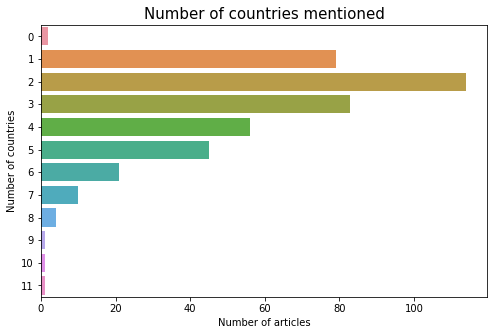

In [86]:
# Number of articles for each individual country 
visualize_number(politics_df)

In [87]:
# Articles that have an overlap in talking about several countries.
politics_df[politics_df.num_countries>1]['article']

1      Labour plans maternity pay rise Maternity pay ...
2      Watchdog probes mail deletions information com...
3      Hewitt decries career sexism Plans extend paid...
5      Brown ally rejects Budget spree Chancellor Gor...
6      Errors doomed first Dome sale initial attempt ...
                             ...                        
411    Howard unfinished business He finished yet whi...
412    Last chance warning voters People England Scot...
415    Labour MP praises Tory campaign Conservatives ...
416    Top Tories Lib Dem hit list Liberal Democrats ...
417    Lib Dems unveil election slogan Liberal Democr...
Name: article, Length: 336, dtype: object

In [49]:
topics_pipeline(politics_df)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
Topic 1:,labour,howard,party,blair,election,people,tory,government,tories,minister
Topic 2:,lords,terror,suspects,rights,trial,human rights,human,law,clarke,home
Topic 3:,ukip,kilroy,kilroy silk,silk,party,veritas,hockney,robert kilroy,robert,independence party
Topic 4:,brown,blair,chancellor,labour,prime,prime minister,election,book,minister,gordon brown
Topic 5:,workers,unions,pension,union,public sector,sector,choice,strike,public,prescott
Topic 6:,eu,straw,constitution,referendum,china,uk,foreign,european,embargo,foreign secretary
Topic 7:,tax,council tax,budget,taxes,council,spending,kennedy,lib,election,cuts
Topic 8:,cards,id,id cards,shadow cabinet,bill,scheme,home,introduce,whether,sources
Topic 9:,hunting,hunt,ban,hunts,dogs,police,law,countryside,hunting dogs,alliance
Topic 10:,lord,goldsmith,lord chancellor,lord goldsmith,advice,lords,answer,speaker,falconer,attorney


## Politics Cluster topics

Topic 1: Labour party related news 

Topic 2: Human rights

Topic 3: Veritas and UKIP

Topic 4: Prime Minister news

Topic 5: Public sector and unions

Topic 6: Foreign policy

Topic 7: Taxes and budget

Topic 8: Id cards related

Topic 9: Hunting laws

Topic 10: Peter Goldsmith related news

# Entertainment Articles Results

In [50]:
n=0
entertainment={}
while True:
    try:
        n=n+1
        file = open('entertainment/'+str(n).zfill(3)+'.txt', "r")
        entertainment[n] = file.read()
    except: break

In [51]:
entertainment_df = countries_pipeline(entertainment)

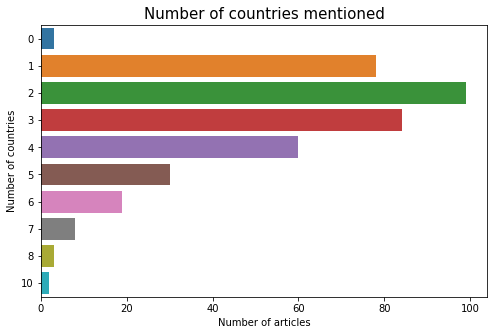

In [88]:
# Number of articles for each individual country 
visualize_number(entertainment_df)

In [89]:
# Articles that have an overlap in talking about several countries.
entertainment_df[entertainment_df.num_countries>1]['article']

1      Gallery unveils interactive tree Christmas tre...
2      Jarre joins fairytale celebration French music...
3      Musical treatment Capra film classic film Wond...
4      Richard Judy choose top books authors shortlis...
5      Poppins musical gets flying start stage adapta...
                             ...                        
382    Last Star Wars children sixth final Star Wars ...
383    French honour director Parker British film dir...
384    Robots march US cinema summit Animated movie R...
385    Hobbit picture four years away Lord Rings dire...
386    Buffy creator joins Wonder Woman creator Buffy...
Name: article, Length: 305, dtype: object

In [52]:
topics_pipeline(entertainment_df)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
Topic 1:,film,book,films,movie,director,actor,role,star,years,children
Topic 2:,band,album,music,rock,best,song,tour,singer,us,pop
Topic 3:,best,awards,film,aviator,award,actress,oscars,foxx,actor,named
Topic 4:,box office,office,box,fockers,meet,weekend,meet fockers,comedy,took,takings
Topic 5:,festival,film,berlin,film festival,films,berlin film,day,michael,february,cinema
Topic 6:,show,bbc,tv,series,audience,radio,television,million,channel,us
Topic 7:,number,elvis,number one,one,chart,album,presley,top,single,singles
Topic 8:,chart,download,sales,singles,bpi,downloads,singles chart,digital,uk,physical
Topic 9:,music,industry,piracy,music industry,copyright,urban,sales,government,germany,radio
Topic 10:,big brother,brother,bez,big,favourite,odds,celebrity,ladbrokes,lush,celebrity big


## Entertainment Cluster topics

Topic 1: Film magazines and books 

Topic 2: Music Tours

Topic 3: Oscar news

Topic 4: Box Office news

Topic 5: Film festival and news

Topic 6: BBC TV and news

Topic 7: Elvis Presley album

Topic 8: Latest hits and charts

Topic 9: Music industry and piracy

Topic 10: Big Brother reality show

# Business Articles Results

In [53]:
n=0
business={}
while True:
    try:
        n=n+1
        file = open('business/'+str(n).zfill(3)+'.txt', "r")
        business[n] = file.read()
    except: break

In [54]:
business_df = countries_pipeline(business)

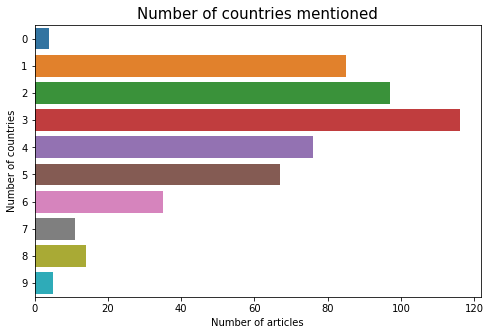

In [90]:
# Number of articles for each individual country 
visualize_number(business_df)

In [91]:
# Articles that have an overlap in talking about several countries.
business_df[business_df.num_countries>1]['article']

1      Ad sales boost Time Warner profit Quarterly pr...
2      Dollar gains Greenspan speech dollar hit highe...
3      Yukos unit buyer faces loan claim owners embat...
4      High fuel prices hit BA profits British Airway...
5      Pernod takeover talk lifts Domecq Shares UK dr...
                             ...                        
505    China top trader Japan China overtook US becom...
506    Trial begins Spain top banker trial Emilio Bot...
507    UK economy ends spurt UK economy grew estimate...
509    Euro firms miss optimism More large companies ...
510    Lacroix label bought US firm Luxury goods grou...
Name: article, Length: 421, dtype: object

In [76]:
topics_pipeline(business_df)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10
Topic 1:,economy,growth,rates,rate,figures,economic,bank,consumer,interest,quarter
Topic 2:,yukos,russian,gazprom,yugansk,rosneft,court,russia,oil,auction,khodorkovsky
Topic 3:,company,shares,firm,sales,us,market,profits,india,new,china
Topic 4:,lse,boerse,deutsche boerse,deutsche,euronext,bid,london,offer,exchange,stock
Topic 5:,budget,deficit,bush,spending,congress,president,budget deficit,tax,military,administration
Topic 6:,ebbers,worldcom,sullivan,fraud,mci,accounting,former,trial,witness,guilty
Topic 7:,dollar,euro,us,currency,deficit,trade,yen,trading,exports,record
Topic 8:,oil,crude,prices,barrel,opec,oil prices,us crude,winter,weather,us
Topic 9:,glazer,club,united,manchester,manchester united,bid,board,proposal,magnier,mcmanus
Topic 10:,fiat,gm,car,general motors,engines,motors,auto,italian,stake,sell


## Business Cluster topics

Topic 1: Economic growth 

Topic 2: Russia's Oil Production

Topic 3: Overall economic scenario and earning reports

Topic 4: Automotive industry 

Topic 5: Economy of South Asian countries 

Topic 6: US stock market and news

Topic 7: European stock market and news

Topic 8: India, US and China relations and economy

Topic 9: US economy

Topic 10: Germantrade and economy